In [19]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt

In [2]:
batch_size = 128
epochs = 10
seed = 1
log_interval=10

In [3]:
device = torch.device("cpu")

kwargs = {} #{'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# Reconstruction + KL divergence losses summed over all elements and batch
def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [7]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 547.025879
Train Epoch: 1 [1280/60000 (2%)]	Loss: 284.563232
Train Epoch: 1 [2560/60000 (4%)]	Loss: 231.192139
Train Epoch: 1 [3840/60000 (6%)]	Loss: 222.522827
Train Epoch: 1 [5120/60000 (9%)]	Loss: 210.933990
Train Epoch: 1 [6400/60000 (11%)]	Loss: 211.606079
Train Epoch: 1 [7680/60000 (13%)]	Loss: 204.297852
Train Epoch: 1 [8960/60000 (15%)]	Loss: 205.146683
Train Epoch: 1 [10240/60000 (17%)]	Loss: 189.331436
Train Epoch: 1 [11520/60000 (19%)]	Loss: 187.073959
Train Epoch: 1 [12800/60000 (21%)]	Loss: 185.480789
Train Epoch: 1 [14080/60000 (23%)]	Loss: 180.326218
Train Epoch: 1 [15360/60000 (26%)]	Loss: 165.922394
Train Epoch: 1 [16640/60000 (28%)]	Loss: 164.612122
Train Epoch: 1 [17920/60000 (30%)]	Loss: 165.067703
Train Epoch: 1 [19200/60000 (32%)]	Loss: 165.942261
Train Epoch: 1 [20480/60000 (34%)]	Loss: 167.486771
Train Epoch: 1 [21760/60000 (36%)]	Loss: 155.215118
Train Epoch: 1 [23040/60000 (38%)]	Loss: 154.626419
Train Epoch: 1 [24320/60000 

Train Epoch: 4 [17920/60000 (30%)]	Loss: 110.649536
Train Epoch: 4 [19200/60000 (32%)]	Loss: 113.165970
Train Epoch: 4 [20480/60000 (34%)]	Loss: 111.023514
Train Epoch: 4 [21760/60000 (36%)]	Loss: 116.506752
Train Epoch: 4 [23040/60000 (38%)]	Loss: 113.782555
Train Epoch: 4 [24320/60000 (41%)]	Loss: 116.254349
Train Epoch: 4 [25600/60000 (43%)]	Loss: 113.281227
Train Epoch: 4 [26880/60000 (45%)]	Loss: 113.308220
Train Epoch: 4 [28160/60000 (47%)]	Loss: 113.555099
Train Epoch: 4 [29440/60000 (49%)]	Loss: 110.556129
Train Epoch: 4 [30720/60000 (51%)]	Loss: 107.760391
Train Epoch: 4 [32000/60000 (53%)]	Loss: 110.560669
Train Epoch: 4 [33280/60000 (55%)]	Loss: 108.563431
Train Epoch: 4 [34560/60000 (58%)]	Loss: 112.879105
Train Epoch: 4 [35840/60000 (60%)]	Loss: 106.453819
Train Epoch: 4 [37120/60000 (62%)]	Loss: 113.769928
Train Epoch: 4 [38400/60000 (64%)]	Loss: 111.125694
Train Epoch: 4 [39680/60000 (66%)]	Loss: 110.161461
Train Epoch: 4 [40960/60000 (68%)]	Loss: 116.289825
Train Epoch:

Train Epoch: 7 [35840/60000 (60%)]	Loss: 105.072510
Train Epoch: 7 [37120/60000 (62%)]	Loss: 109.183853
Train Epoch: 7 [38400/60000 (64%)]	Loss: 105.086273
Train Epoch: 7 [39680/60000 (66%)]	Loss: 106.783234
Train Epoch: 7 [40960/60000 (68%)]	Loss: 104.568848
Train Epoch: 7 [42240/60000 (70%)]	Loss: 104.996971
Train Epoch: 7 [43520/60000 (72%)]	Loss: 106.934372
Train Epoch: 7 [44800/60000 (75%)]	Loss: 108.769241
Train Epoch: 7 [46080/60000 (77%)]	Loss: 108.929474
Train Epoch: 7 [47360/60000 (79%)]	Loss: 111.264587
Train Epoch: 7 [48640/60000 (81%)]	Loss: 108.214523
Train Epoch: 7 [49920/60000 (83%)]	Loss: 107.332886
Train Epoch: 7 [51200/60000 (85%)]	Loss: 106.995171
Train Epoch: 7 [52480/60000 (87%)]	Loss: 106.966515
Train Epoch: 7 [53760/60000 (90%)]	Loss: 104.431633
Train Epoch: 7 [55040/60000 (92%)]	Loss: 106.784683
Train Epoch: 7 [56320/60000 (94%)]	Loss: 108.526794
Train Epoch: 7 [57600/60000 (96%)]	Loss: 107.035675
Train Epoch: 7 [58880/60000 (98%)]	Loss: 110.335449
====> Epoch:

Train Epoch: 10 [52480/60000 (87%)]	Loss: 105.605591
Train Epoch: 10 [53760/60000 (90%)]	Loss: 110.662720
Train Epoch: 10 [55040/60000 (92%)]	Loss: 107.156509
Train Epoch: 10 [56320/60000 (94%)]	Loss: 107.546997
Train Epoch: 10 [57600/60000 (96%)]	Loss: 108.699417
Train Epoch: 10 [58880/60000 (98%)]	Loss: 104.019058
====> Epoch: 10 Average loss: 106.2281
====> Test set loss: 105.6477


In [9]:
from sklearn.manifold import TSNE

#Here I have just created one more trainloader which can help me out in the displaying of the images
viz_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),batch_size=1000, shuffle=True, **kwargs)
dataiter = iter(viz_loader)
images, labels = dataiter.next()

In [12]:
imgs = images.view(1000, 784)

In [13]:
mean, logvar  = model.encode(imgs)

In [17]:
#z = model.get_hidden(mean, logvar)

#Since my latent state consists of 8 dimensions, I must first reduce it to 2 dimensions so as to be able to
#visualize them
z_embedded = TSNE(n_components=2).fit_transform(mean.detach().numpy())

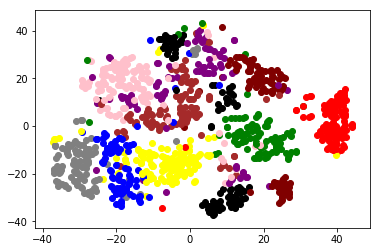

In [20]:
for i in range(1000):
    if(labels[i].numpy() == 0):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='black')
    elif(labels[i].numpy() == 1):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='red')
    elif(labels[i].numpy() == 2):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='green')
    elif(labels[i].numpy() == 3):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='pink')
    elif(labels[i].numpy() == 4):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='gray')
    elif(labels[i].numpy() == 5):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='purple')
    elif(labels[i].numpy() == 6):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='maroon')
    elif(labels[i].numpy() == 7):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='yellow')
    elif(labels[i].numpy() == 8):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='brown')
    elif(labels[i].numpy() == 9):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='blue')
        
    plt.plot()